## Notebook to investigate Iterative Nullspace Projection for Amnesic Probing

### 1. Variance and cosine similarity of the representations after Iterative Nullspace Projection

In [35]:
import utils
import utils_amnesic_probing
import pickle
import torch
from collections import defaultdict

def get_representations(dataset, split, layer, amnesic_objective, N_projections, N_patches=None):
    """ input:
    N_projections (string) = ["all", "first", "each"]
    """
    threshold = 30 # ignore images with more than 30 object patches

    repr_path = f"../data/{dataset}/representations/{dataset}_{split}_visual.pickle"

    with open(repr_path, "rb") as f:
        repr = pickle.load(f)

    original = []

    if N_projections == "each":
        amnesic = defaultdict(lambda: [])
    else:
        amnesic = []

    file_name_patches = (
        f"../data/{dataset}/representations/{dataset}_{split}_patches.pickle"
    )

    with open(file_name_patches, "rb") as f:
        objectpatches = pickle.load(f)

    if N_projections == "all":
        P = utils_amnesic_probing.open_intersection_nullspaces(dataset, amnesic_objective, layer)
        P = torch.from_numpy(P)
    elif N_projections == "first":
        P = utils_amnesic_probing.open_first_rowspace_projection(dataset, amnesic_objective, layer)
        P = torch.from_numpy(P)
    elif N_projections == "each":
        path = f"../data/{dataset}/representations/rowspace_projections_{amnesic_objective}_layer{layer}.pickle"
        with open(path, "rb") as f:
            Ps = pickle.load(f)
        P_dict = {}
        for i in range(1, len(Ps)+1):
            P = utils_amnesic_probing.get_projection_to_intersection_of_nullspaces(Ps[:i], input_dim = 768)
            P = torch.from_numpy(P)
            P_dict[i] = P

    count = 0
    for img_id, repr in repr.items():
        
        patches = objectpatches[img_id]
        nodes = patches.keys()

        if len(nodes) <= threshold:
            input = utils.filter_repr(layer, nodes, repr, single_patch=True, padding_up_to=threshold)
            for i, patch_id in enumerate(nodes):
                patch = input[i]
                boxes = patches[patch_id]
                if len(boxes) > 1:
                    continue
                if N_patches is not None:
                    if count >= N_patches:
                        break
                    count += 1
                original.append(patch)
                if N_projections == "all" or N_projections == "first":
                    z = torch.from_numpy(patch)
                    z = torch.unsqueeze(z,0)
                    z = z.to(torch.float32)
                    P = P.to(torch.float32)
                    z = z @ P
                    amnesic_z = z.flatten()
                    amnesic.append(amnesic_z)
                elif N_projections == "each":
                    for j in range(1, len(Ps)+1):
                        P = P_dict[j]
                        # P = utils_amnesic_probing.get_projection_to_intersection_of_nullspaces(Ps[:i])
                        # P = torch.from_numpy(P)
                        z = torch.from_numpy(patch)
                        z = torch.unsqueeze(z,0)
                        z = z.to(torch.float32)
                        P = P.to(torch.float32)
                        z = z @ P
                        amnesic_z = z.flatten()
                        amnesic[len(original)-1].append(amnesic_z)

    print("count: ", count)
    return original, amnesic

# original_0, amnesic_0 = get_representations(dataset="pos", split="val", layer=0, amnesic_objective="shape", N_projections="all")

In [36]:
original_6, amnesic_6 = get_representations(dataset="pos", split="val", layer=6, amnesic_objective="shape", N_projections="each", N_patches=100)

count:  100


In [38]:
print(len(original_6))
print(original_6[0].size)
print(len(amnesic_6))
print(len(amnesic_6[0]))

100
768
100
71


In [42]:
type(amnesic_6)

collections.defaultdict

In [60]:
from numpy import dot
from numpy.linalg import norm
import collections
import numpy as np

def get_cos_sim(original, amnesic):
    if type(amnesic) == collections.defaultdict or type(amnesic) == dict:
        cos_sims = defaultdict(lambda: [])
        for i in range(len(original)):
            for j, proj_j in enumerate(amnesic[i]):
                cos_sim = dot(original[i], proj_j)/(norm(original[i])*norm(proj_j))
                cos_sims[j].append(cos_sim)
        for layer, cos_sim in cos_sims.items():
            cos_sims[layer] = np.mean(cos_sim), np.std(cos_sim)
        return dict(cos_sims)
    elif type(amnesic) == list:
        cos_sims = []
        for i in range(len(original)):
            cos_sim = dot(original[i], amnesic[i])/(norm(original[i])*norm(amnesic[i]))
            cos_sims.append(cos_sim)
        return np.mean(cos_sims), np.std(cos_sims)

cos_sims = get_cos_sim(original_6, amnesic_6)
print(cos_sims)

{0: (0.989896, 0.005602971), 1: (0.9813286, 0.008746027), 2: (0.9709736, 0.01142274), 3: (0.95268476, 0.014211025), 4: (0.94155455, 0.01668294), 5: (0.92387795, 0.018587986), 6: (0.89471596, 0.02069652), 7: (0.8634617, 0.025474723), 8: (0.8515704, 0.027254537), 9: (0.8457154, 0.028197702), 10: (0.8391916, 0.028394058), 11: (0.8311053, 0.028423483), 12: (0.82298476, 0.029518101), 13: (0.816585, 0.030823182), 14: (0.8125681, 0.030940637), 15: (0.80605805, 0.03125427), 16: (0.80043006, 0.031816334), 17: (0.7947105, 0.031676833), 18: (0.79016614, 0.03252039), 19: (0.78613454, 0.032904513), 20: (0.7822229, 0.032685224), 21: (0.7779938, 0.032557797), 22: (0.77373445, 0.032486603), 23: (0.76767784, 0.033098456), 24: (0.7623496, 0.03286527), 25: (0.75689924, 0.0336973), 26: (0.75010127, 0.033568207), 27: (0.7439459, 0.03404695), 28: (0.7383091, 0.033642765), 29: (0.7331464, 0.033454377), 30: (0.7279701, 0.034232814), 31: (0.7226792, 0.03385888), 32: (0.7161404, 0.033240966), 33: (0.71002585, 0

count:  100
count:  100
count:  100
count:  100
count:  100


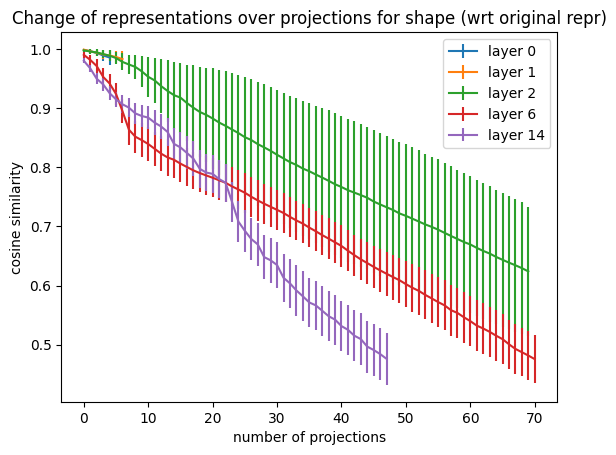

In [67]:
import matplotlib.pyplot as plt

def plot_cossims(layers: list, amnesic_objective, N_patches=100):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    for layer in layers:
        original, amnesic = get_representations(dataset="pos", split="val", layer=layer, amnesic_objective=amnesic_objective, N_projections="each", N_patches=N_patches)
        cos_sims = get_cos_sim(original, amnesic)

        x = [key for key in cos_sims.keys()]
        while len(x) < 72:
            x.append(np.nan)
        y = [mean for mean, std in cos_sims.values()]
        while len(y) < 72:
            y.append(np.nan)
        yerr = [std for mean, std in cos_sims.values()]
        while len(yerr) <72:
            yerr.append(np.nan)        
        ax.errorbar(x, y, yerr, label=f"layer {layer}")
    # plt.plot(cos_sims.keys(), cos_sims.values(), label="layer 6")
    plt.ylabel("cosine similarity")
    plt.xlabel("number of projections")
    plt.title(f"Change of representations over projections for {amnesic_objective} (wrt original repr)")
    ax.legend()
    plt.show()

plot_cossims(layers=[0,1,2,6,14], amnesic_objective="shape")

count:  100
count:  100
count:  100
count:  100
count:  100


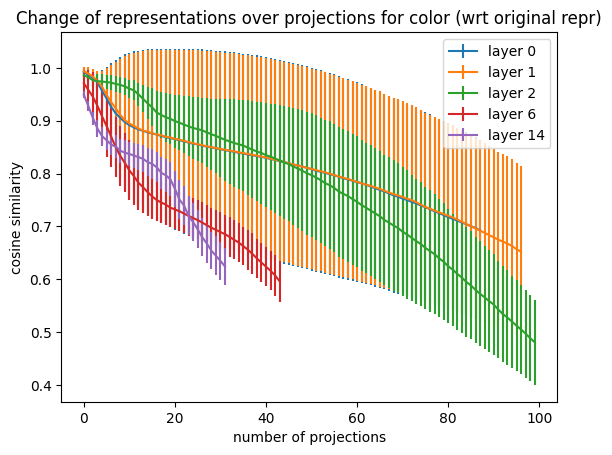

In [68]:
plot_cossims(layers=[0,1,2,6,14], amnesic_objective="color")

In [26]:
def get_all_cossim_layers(dataset, split, amnesic_objective, N_projections):
    results = {}
    for layer in range(15):
        original, amnesic = get_representations(dataset, split, layer, amnesic_objective, N_projections)
        cos_sim = get_cos_sim(original, amnesic)
        results[layer] = cos_sim
    return results

get_all_cossim_layers(dataset="pos", split="val", amnesic_objective="color", N_projections="all")

{0: 0.6540134303482517,
 1: 0.6181722042332096,
 2: 0.46607702039287346,
 3: 0.3532137670369134,
 4: 0.5308192574865813,
 5: 0.6070621602662924,
 6: 0.5968611360373617,
 7: 0.6511361465807045,
 8: 0.6381134049901309,
 9: 0.5628325855157522,
 10: 0.6531695814175631,
 11: 0.567289475565263,
 12: 0.5534526734808906,
 13: 0.6789319913711503,
 14: 0.6331713337538715}

In [27]:
get_all_cossim_layers(dataset="pos", split="val", amnesic_objective="shape", N_projections="all")

{0: 0.9845801022748422,
 1: 0.9815290306342299,
 2: 0.615261632648348,
 3: 0.553935966409016,
 4: 0.6638654228013813,
 5: 0.5629553082142473,
 6: 0.47345682809780526,
 7: 0.6002444857453831,
 8: 0.5640201843213273,
 9: 0.6133341747071079,
 10: 0.5481380929416609,
 11: 0.5219037188519913,
 12: 0.5815517434172245,
 13: 0.6136724187587846,
 14: 0.471739972804445}